In [6]:
import os
import cv2
from deepface import DeepFace
#from deepface.modules import functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Local descriptors
from skimage.feature import hog, local_binary_pattern
from skimage import  exposure
from skimage import feature

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict



In [7]:
def GetPredictions(X_train, X_test, y_train, y_test, model, parameters):
    model_name = type(model).__name__
    print(f"{model_name} training...")
    t0 = time()
    
    # Grid search across parameter range
    clf = GridSearchCV(model, parameters, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(X_test)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

In [8]:
def calc_embs(model, X):
    norm_images = prewhiten(X)
    pd = []
    for image in norm_images:
        pd.append(model.forward(np.expand_dims(image, axis=0)))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [9]:
def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    try:
        cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")

In [10]:
# Data location
folder = "data/rvf10k/train"
dest_folder = "data/roi_dataset"

cascade_path = "data/haarcascade_frontalface_default.xml"


# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []

n_images = 0

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))

            # Extract face as ROI
            faceCascade = cv2.CascadeClassifier(cascade_path)
            faces = faceCascade.detectMultiScale(
                image,
                scaleFactor=1.3,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) > 0:
                for x, y, w, h in faces:
                    image = image[y:y + h, x:x + w]
                    save_image_with_error_handling(dest_folder, class_name, n_images, image)
                    n_images += 1
            else:
                cv2.imwrite(
                    os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
                n_images += 1

An error occurred while saving image 2979: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 4222: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 5718: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

An error occurred while saving image 6045: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'



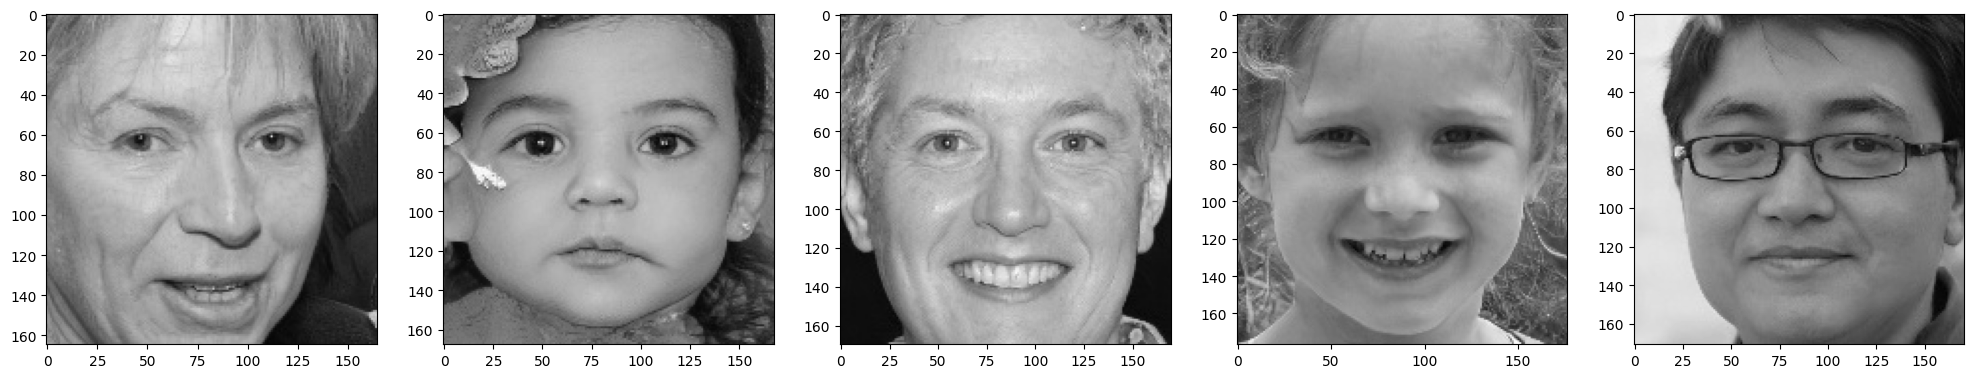

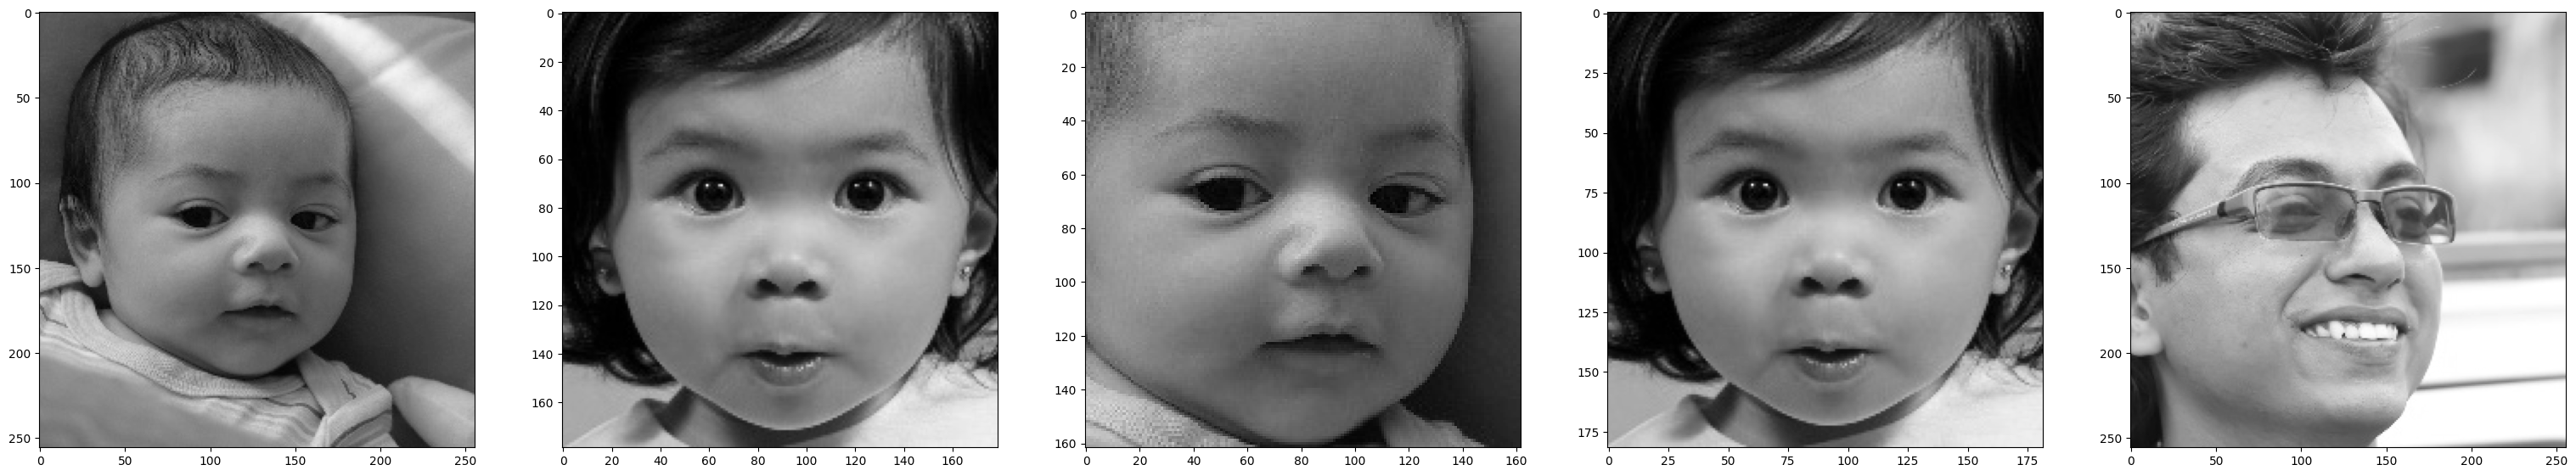

Features
(7008,)
(7008,)


In [11]:
# Deepface
# Available models ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model_deepface = DeepFace.build_model("ArcFace")

target_size = (model_deepface.input_shape[0], model_deepface.input_shape[1])
dim = (int(target_size[0]), int(target_size[1]))

# Data location
folder = "data/roi_dataset"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []
# Initialize data structures and their corresponding labels
X = []
Y = []
XFaceNet = []

# Default resolution value for matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Number of sample images from each class to show
nims2show = 5

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))
            
            # Extract sizes
            height, width, depth = image.shape
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X.append(gray.reshape(height * width))
            
            # Deepface with FaceNet
            # Get embeddings
            img_embedding = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            img_embedding = calc_embs(model_deepface, np.expand_dims(img_embedding, axis=0))
            XFaceNet.append(img_embedding[0])
                    
            # Add numerical label of the sample
            Y.append(nclasses - 1)
            
            # Show the first nims2show samples of each class
            if nsamples < nims2show:
                if nsamples == 0:
                    figsize = 15 * width / float(dpi), 15 * height / float(dpi)
                    fig = plt.figure(figsize=figsize)
                
                fig.add_subplot(1, nims2show, nsamples + 1)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
            
            # Increase the number of samples
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
# Convert X and Y to numpy arrays
Y = np.array(Y, dtype='float64')
XFaceNet = np.array(XFaceNet, dtype='float32')

# Show information about the read dataset
# Debugging
print("Features")
print(XFaceNet.shape)
print(Y.shape)
# Get number of samples and features
# Get names of the classes
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

In [14]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

# Store file paths
file_paths = []
for class_name in os.listdir(folder):
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith('.jpg'):
            file_paths.append(os.path.join(class_folder, file_name))

folds = [[] for _ in range(5)]

fold = 1
for train_index, test_index in skf.split(X, Y):
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    
    fold_files = [file_paths[i] for i in test_index]
    folds[fold - 1] = fold_files
    
    fold += 1

# Save file paths to a file
with open('folds.txt', 'w') as f:
    for i, fold_files in enumerate(folds):
        f.write(f"Files in fold {i + 1}:\n")
        for file_path in fold_files:
            f.write(file_path + '\n')
        f.write('\n')

# Folds are also saved in the variable 'folds'

Fold 1
# samples in training set 5606
# samples in test set 1402
Fold 2
# samples in training set 5606
# samples in test set 1402
Fold 3
# samples in training set 5606
# samples in test set 1402
Fold 4
# samples in training set 5607
# samples in test set 1401
Fold 5
# samples in training set 5607
# samples in test set 1401


In [23]:
# Analyze images. Save imagepath to another file if no face found. Summarize results
analysis_results = []
failed_images = []

for i, fold_files in enumerate(folds):
    fold_results = defaultdict(lambda: defaultdict(int))
    for file_path in fold_files:
        try:
            objs = DeepFace.analyze(img_path=file_path, actions=['age', 'gender', 'race', 'emotion'])
            for obj in objs:  # iterate through the list of analysis results
                for key, value in obj.items():
                    if key in ['age', 'gender', 'race', 'emotion']:
                        if isinstance(value, dict):  # e.g., emotion analysis returns a dictionary
                            for sub_key, sub_value in value.items():
                                fold_results[key][sub_key] += sub_value
                        else:
                            fold_results[key][value] += 1
        except ValueError as e:
            print(f"Failed to analyze {file_path}: {e}")
            failed_images.append(file_path)
    analysis_results.append(fold_results)

# Save analysis results to a file
with open('analysis_summary.txt', 'w') as f:
    for i, fold_results in enumerate(analysis_results):
        f.write(f"Summary for fold {i + 1}:\n")
        for key, value in fold_results.items():
            f.write(f"{key}:\n")
            for sub_key, sub_value in value.items():
                f.write(f"  {sub_key}: {sub_value}\n")
        f.write('\n')

# Save failed images to a file
with open('failed_images.txt', 'w') as f:
    f.write("Images where face detection failed:\n")
    for file_path in failed_images:
        f.write(file_path + '\n')

# Print analysis results (optional)
for i, fold_results in enumerate(analysis_results):
    print(f"Summary for fold {i + 1}:")
    for key, value in fold_results.items():
        print(f"{key}:")
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    print('\n')

# Print failed images (optional)
print("Images where face detection failed:")
for file_path in failed_images:
    print(file_path)

Finding actions:   0%|          | 0/4 [00:00<?, ?it/s]

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Failed to analyze data/roi_dataset\fake\1036_faces.jpg: Face could not be detected in data/roi_dataset\fake\1036_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


Failed to analyze data/roi_dataset\fake\1349_faces.jpg: Face could not be detected in data/roi_dataset\fake\1349_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.52it/s]


Failed to analyze data/roi_dataset\fake\1375_faces.jpg: Face could not be detected in data/roi_dataset\fake\1375_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Failed to analyze data/roi_dataset\fake\1420_faces.jpg: Face could not be detected in data/roi_dataset\fake\1420_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Failed to analyze data/roi_dataset\fake\1440_faces.jpg: Face could not be detected in data/roi_dataset\fake\1440_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.61it/s]


Failed to analyze data/roi_dataset\fake\1498_faces.jpg: Face could not be detected in data/roi_dataset\fake\1498_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


Failed to analyze data/roi_dataset\fake\1503_faces.jpg: Face could not be detected in data/roi_dataset\fake\1503_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]


Failed to analyze data/roi_dataset\fake\1545_faces.jpg: Face could not be detected in data/roi_dataset\fake\1545_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


Failed to analyze data/roi_dataset\fake\1586_faces.jpg: Face could not be detected in data/roi_dataset\fake\1586_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\1587_faces.jpg: Face could not be detected in data/roi_dataset\fake\1587_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


Failed to analyze data/roi_dataset\fake\1624_faces.jpg: Face could not be detected in data/roi_dataset\fake\1624_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Failed to analyze data/roi_dataset\fake\1690_faces.jpg: Face could not be detected in data/roi_dataset\fake\1690_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Failed to analyze data/roi_dataset\fake\1708_faces.jpg: Face could not be detected in data/roi_dataset\fake\1708_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Failed to analyze data/roi_dataset\fake\1723_faces.jpg: Face could not be detected in data/roi_dataset\fake\1723_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


Failed to analyze data/roi_dataset\fake\1824_faces.jpg: Face could not be detected in data/roi_dataset\fake\1824_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Failed to analyze data/roi_dataset\fake\1855_faces.jpg: Face could not be detected in data/roi_dataset\fake\1855_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.65it/s]


Failed to analyze data/roi_dataset\fake\1937_faces.jpg: Face could not be detected in data/roi_dataset\fake\1937_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


Failed to analyze data/roi_dataset\fake\2023_faces.jpg: Face could not be detected in data/roi_dataset\fake\2023_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.59it/s]


Failed to analyze data/roi_dataset\fake\2077_faces.jpg: Face could not be detected in data/roi_dataset\fake\2077_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.48it/s]


Failed to analyze data/roi_dataset\fake\2106_faces.jpg: Face could not be detected in data/roi_dataset\fake\2106_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Failed to analyze data/roi_dataset\fake\2151_faces.jpg: Face could not be detected in data/roi_dataset\fake\2151_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


Failed to analyze data/roi_dataset\fake\220_faces.jpg: Face could not be detected in data/roi_dataset\fake\220_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\2215_faces.jpg: Face could not be detected in data/roi_dataset\fake\2215_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Failed to analyze data/roi_dataset\fake\2243_faces.jpg: Face could not be detected in data/roi_dataset\fake\2243_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


Failed to analyze data/roi_dataset\fake\2250_faces.jpg: Face could not be detected in data/roi_dataset\fake\2250_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


Failed to analyze data/roi_dataset\fake\2265_faces.jpg: Face could not be detected in data/roi_dataset\fake\2265_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.38it/s]


Failed to analyze data/roi_dataset\fake\2315_faces.jpg: Face could not be detected in data/roi_dataset\fake\2315_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.43it/s]


Failed to analyze data/roi_dataset\fake\2341_faces.jpg: Face could not be detected in data/roi_dataset\fake\2341_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


Failed to analyze data/roi_dataset\fake\2349_faces.jpg: Face could not be detected in data/roi_dataset\fake\2349_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Failed to analyze data/roi_dataset\fake\2360_faces.jpg: Face could not be detected in data/roi_dataset\fake\2360_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\2365_faces.jpg: Face could not be detected in data/roi_dataset\fake\2365_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.36it/s]


Failed to analyze data/roi_dataset\fake\2392_faces.jpg: Face could not be detected in data/roi_dataset\fake\2392_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


Failed to analyze data/roi_dataset\fake\2404_faces.jpg: Face could not be detected in data/roi_dataset\fake\2404_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.64it/s]


Failed to analyze data/roi_dataset\fake\2466_faces.jpg: Face could not be detected in data/roi_dataset\fake\2466_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Failed to analyze data/roi_dataset\fake\2559_faces.jpg: Face could not be detected in data/roi_dataset\fake\2559_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Failed to analyze data/roi_dataset\fake\2629_faces.jpg: Face could not be detected in data/roi_dataset\fake\2629_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


Failed to analyze data/roi_dataset\fake\2643_faces.jpg: Face could not be detected in data/roi_dataset\fake\2643_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]


Failed to analyze data/roi_dataset\fake\2650_faces.jpg: Face could not be detected in data/roi_dataset\fake\2650_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Failed to analyze data/roi_dataset\fake\2669_faces.jpg: Face could not be detected in data/roi_dataset\fake\2669_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


Failed to analyze data/roi_dataset\fake\267_faces.jpg: Face could not be detected in data/roi_dataset\fake\267_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Failed to analyze data/roi_dataset\fake\2701_faces.jpg: Face could not be detected in data/roi_dataset\fake\2701_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]


Failed to analyze data/roi_dataset\fake\271_faces.jpg: Face could not be detected in data/roi_dataset\fake\271_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]


Failed to analyze data/roi_dataset\fake\2778_faces.jpg: Face could not be detected in data/roi_dataset\fake\2778_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]


Failed to analyze data/roi_dataset\fake\2851_faces.jpg: Face could not be detected in data/roi_dataset\fake\2851_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


Failed to analyze data/roi_dataset\fake\2935_faces.jpg: Face could not be detected in data/roi_dataset\fake\2935_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]


Failed to analyze data/roi_dataset\fake\2972_faces.jpg: Face could not be detected in data/roi_dataset\fake\2972_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Failed to analyze data/roi_dataset\fake\3010_faces.jpg: Face could not be detected in data/roi_dataset\fake\3010_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Failed to analyze data/roi_dataset\fake\3101_faces.jpg: Face could not be detected in data/roi_dataset\fake\3101_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Failed to analyze data/roi_dataset\fake\3147_faces.jpg: Face could not be detected in data/roi_dataset\fake\3147_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


Failed to analyze data/roi_dataset\fake\3179_faces.jpg: Face could not be detected in data/roi_dataset\fake\3179_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Failed to analyze data/roi_dataset\fake\3196_faces.jpg: Face could not be detected in data/roi_dataset\fake\3196_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]


Failed to analyze data/roi_dataset\fake\3200_faces.jpg: Face could not be detected in data/roi_dataset\fake\3200_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Failed to analyze data/roi_dataset\fake\3222_faces.jpg: Face could not be detected in data/roi_dataset\fake\3222_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Failed to analyze data/roi_dataset\fake\3237_faces.jpg: Face could not be detected in data/roi_dataset\fake\3237_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


Failed to analyze data/roi_dataset\fake\3258_faces.jpg: Face could not be detected in data/roi_dataset\fake\3258_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Failed to analyze data/roi_dataset\fake\3376_faces.jpg: Face could not be detected in data/roi_dataset\fake\3376_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\3379_faces.jpg: Face could not be detected in data/roi_dataset\fake\3379_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Failed to analyze data/roi_dataset\fake\3397_faces.jpg: Face could not be detected in data/roi_dataset\fake\3397_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Failed to analyze data/roi_dataset\fake\3416_faces.jpg: Face could not be detected in data/roi_dataset\fake\3416_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]


Failed to analyze data/roi_dataset\fake\3497_faces.jpg: Face could not be detected in data/roi_dataset\fake\3497_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Failed to analyze data/roi_dataset\fake\390_faces.jpg: Face could not be detected in data/roi_dataset\fake\390_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


Failed to analyze data/roi_dataset\fake\497_faces.jpg: Face could not be detected in data/roi_dataset\fake\497_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]


Failed to analyze data/roi_dataset\fake\511_faces.jpg: Face could not be detected in data/roi_dataset\fake\511_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]


Failed to analyze data/roi_dataset\fake\528_faces.jpg: Face could not be detected in data/roi_dataset\fake\528_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\534_faces.jpg: Face could not be detected in data/roi_dataset\fake\534_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Failed to analyze data/roi_dataset\fake\681_faces.jpg: Face could not be detected in data/roi_dataset\fake\681_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Failed to analyze data/roi_dataset\fake\697_faces.jpg: Face could not be detected in data/roi_dataset\fake\697_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Failed to analyze data/roi_dataset\fake\70_faces.jpg: Face could not be detected in data/roi_dataset\fake\70_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.22it/s]


Failed to analyze data/roi_dataset\fake\841_faces.jpg: Face could not be detected in data/roi_dataset\fake\841_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Failed to analyze data/roi_dataset\fake\972_faces.jpg: Face could not be detected in data/roi_dataset\fake\972_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Failed to analyze data/roi_dataset\real\3518_faces.jpg: Face could not be detected in data/roi_dataset\real\3518_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


Failed to analyze data/roi_dataset\real\3528_faces.jpg: Face could not be detected in data/roi_dataset\real\3528_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


Failed to analyze data/roi_dataset\real\3548_faces.jpg: Face could not be detected in data/roi_dataset\real\3548_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


Failed to analyze data/roi_dataset\real\3558_faces.jpg: Face could not be detected in data/roi_dataset\real\3558_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\3560_faces.jpg: Face could not be detected in data/roi_dataset\real\3560_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]


Failed to analyze data/roi_dataset\real\3584_faces.jpg: Face could not be detected in data/roi_dataset\real\3584_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\3585_faces.jpg: Face could not be detected in data/roi_dataset\real\3585_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


Failed to analyze data/roi_dataset\real\3614_faces.jpg: Face could not be detected in data/roi_dataset\real\3614_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\3619_faces.jpg: Face could not be detected in data/roi_dataset\real\3619_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


Failed to analyze data/roi_dataset\real\3650_faces.jpg: Face could not be detected in data/roi_dataset\real\3650_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Failed to analyze data/roi_dataset\real\3681_faces.jpg: Face could not be detected in data/roi_dataset\real\3681_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Failed to analyze data/roi_dataset\real\3700_faces.jpg: Face could not be detected in data/roi_dataset\real\3700_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


Failed to analyze data/roi_dataset\real\3722_faces.jpg: Face could not be detected in data/roi_dataset\real\3722_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Failed to analyze data/roi_dataset\real\3761_faces.jpg: Face could not be detected in data/roi_dataset\real\3761_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]


Failed to analyze data/roi_dataset\real\3774_faces.jpg: Face could not be detected in data/roi_dataset\real\3774_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


Failed to analyze data/roi_dataset\real\3801_faces.jpg: Face could not be detected in data/roi_dataset\real\3801_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


Failed to analyze data/roi_dataset\real\3843_faces.jpg: Face could not be detected in data/roi_dataset\real\3843_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Failed to analyze data/roi_dataset\real\3870_faces.jpg: Face could not be detected in data/roi_dataset\real\3870_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


Failed to analyze data/roi_dataset\real\3881_faces.jpg: Face could not be detected in data/roi_dataset\real\3881_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]


Failed to analyze data/roi_dataset\real\3905_faces.jpg: Face could not be detected in data/roi_dataset\real\3905_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Failed to analyze data/roi_dataset\real\3928_faces.jpg: Face could not be detected in data/roi_dataset\real\3928_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


Failed to analyze data/roi_dataset\real\3950_faces.jpg: Face could not be detected in data/roi_dataset\real\3950_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Failed to analyze data/roi_dataset\real\3965_faces.jpg: Face could not be detected in data/roi_dataset\real\3965_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


Failed to analyze data/roi_dataset\real\3973_faces.jpg: Face could not be detected in data/roi_dataset\real\3973_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


Failed to analyze data/roi_dataset\real\3985_faces.jpg: Face could not be detected in data/roi_dataset\real\3985_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.71it/s]


Failed to analyze data/roi_dataset\real\3991_faces.jpg: Face could not be detected in data/roi_dataset\real\3991_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\3994_faces.jpg: Face could not be detected in data/roi_dataset\real\3994_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]


Failed to analyze data/roi_dataset\real\4006_faces.jpg: Face could not be detected in data/roi_dataset\real\4006_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4015_faces.jpg: Face could not be detected in data/roi_dataset\real\4015_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


Failed to analyze data/roi_dataset\real\4067_faces.jpg: Face could not be detected in data/roi_dataset\real\4067_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Failed to analyze data/roi_dataset\real\4092_faces.jpg: Face could not be detected in data/roi_dataset\real\4092_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


Failed to analyze data/roi_dataset\real\4106_faces.jpg: Face could not be detected in data/roi_dataset\real\4106_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.64it/s]


Failed to analyze data/roi_dataset\real\4150_faces.jpg: Face could not be detected in data/roi_dataset\real\4150_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Failed to analyze data/roi_dataset\real\4188_faces.jpg: Face could not be detected in data/roi_dataset\real\4188_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Failed to analyze data/roi_dataset\real\4210_faces.jpg: Face could not be detected in data/roi_dataset\real\4210_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4212_faces.jpg: Face could not be detected in data/roi_dataset\real\4212_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


Failed to analyze data/roi_dataset\real\4221_faces.jpg: Face could not be detected in data/roi_dataset\real\4221_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Failed to analyze data/roi_dataset\real\4234_faces.jpg: Face could not be detected in data/roi_dataset\real\4234_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


Failed to analyze data/roi_dataset\real\4245_faces.jpg: Face could not be detected in data/roi_dataset\real\4245_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


Failed to analyze data/roi_dataset\real\4255_faces.jpg: Face could not be detected in data/roi_dataset\real\4255_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4264_faces.jpg: Face could not be detected in data/roi_dataset\real\4264_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4275_faces.jpg: Face could not be detected in data/roi_dataset\real\4275_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4276_faces.jpg: Face could not be detected in data/roi_dataset\real\4276_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4279_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.63it/s]


Failed to analyze data/roi_dataset\real\4305_faces.jpg: Face could not be detected in data/roi_dataset\real\4305_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]


Failed to analyze data/roi_dataset\real\4331_faces.jpg: Face could not be detected in data/roi_dataset\real\4331_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Failed to analyze data/roi_dataset\real\4350_faces.jpg: Face could not be detected in data/roi_dataset\real\4350_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]


Failed to analyze data/roi_dataset\real\4361_faces.jpg: Face could not be detected in data/roi_dataset\real\4361_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Failed to analyze data/roi_dataset\real\4392_faces.jpg: Face could not be detected in data/roi_dataset\real\4392_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4404_faces.jpg: Face could not be detected in data/roi_dataset\real\4404_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]


Failed to analyze data/roi_dataset\real\4440_faces.jpg: Face could not be detected in data/roi_dataset\real\4440_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4447_faces.jpg: Face could not be detected in data/roi_dataset\real\4447_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.63it/s]


Failed to analyze data/roi_dataset\real\4458_faces.jpg: Face could not be detected in data/roi_dataset\real\4458_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Failed to analyze data/roi_dataset\real\4466_faces.jpg: Face could not be detected in data/roi_dataset\real\4466_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Failed to analyze data/roi_dataset\real\4480_faces.jpg: Face could not be detected in data/roi_dataset\real\4480_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4484_faces.jpg: Face could not be detected in data/roi_dataset\real\4484_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Failed to analyze data/roi_dataset\real\4524_faces.jpg: Face could not be detected in data/roi_dataset\real\4524_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4528_faces.jpg: Face could not be detected in data/roi_dataset\real\4528_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4529_faces.jpg: Face could not be detected in data/roi_dataset\real\4529_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]


Failed to analyze data/roi_dataset\real\4549_faces.jpg: Face could not be detected in data/roi_dataset\real\4549_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4551_faces.jpg: Face could not be detected in data/roi_dataset\real\4551_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


Failed to analyze data/roi_dataset\real\4608_faces.jpg: Face could not be detected in data/roi_dataset\real\4608_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Failed to analyze data/roi_dataset\real\4616_faces.jpg: Face could not be detected in data/roi_dataset\real\4616_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Failed to analyze data/roi_dataset\real\4636_faces.jpg: Face could not be detected in data/roi_dataset\real\4636_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


Failed to analyze data/roi_dataset\real\4644_faces.jpg: Face could not be detected in data/roi_dataset\real\4644_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


Failed to analyze data/roi_dataset\real\4680_faces.jpg: Face could not be detected in data/roi_dataset\real\4680_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Failed to analyze data/roi_dataset\real\4692_faces.jpg: Face could not be detected in data/roi_dataset\real\4692_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


Failed to analyze data/roi_dataset\real\4702_faces.jpg: Face could not be detected in data/roi_dataset\real\4702_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


Failed to analyze data/roi_dataset\real\4741_faces.jpg: Face could not be detected in data/roi_dataset\real\4741_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]


Failed to analyze data/roi_dataset\real\4746_faces.jpg: Face could not be detected in data/roi_dataset\real\4746_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4760_faces.jpg: Face could not be detected in data/roi_dataset\real\4760_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4761_faces.jpg: Face could not be detected in data/roi_dataset\real\4761_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4769_faces.jpg: Face could not be detected in data/roi_dataset\real\4769_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4770_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]


Failed to analyze data/roi_dataset\real\4792_faces.jpg: Face could not be detected in data/roi_dataset\real\4792_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]


Failed to analyze data/roi_dataset\real\4815_faces.jpg: Face could not be detected in data/roi_dataset\real\4815_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Failed to analyze data/roi_dataset\real\4823_faces.jpg: Face could not be detected in data/roi_dataset\real\4823_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


Failed to analyze data/roi_dataset\real\4836_faces.jpg: Face could not be detected in data/roi_dataset\real\4836_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


Failed to analyze data/roi_dataset\real\4848_faces.jpg: Face could not be detected in data/roi_dataset\real\4848_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]


Failed to analyze data/roi_dataset\real\4852_faces.jpg: Face could not be detected in data/roi_dataset\real\4852_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]


Failed to analyze data/roi_dataset\real\4865_faces.jpg: Face could not be detected in data/roi_dataset\real\4865_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Failed to analyze data/roi_dataset\real\4878_faces.jpg: Face could not be detected in data/roi_dataset\real\4878_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.44it/s]


Failed to analyze data/roi_dataset\real\4914_faces.jpg: Face could not be detected in data/roi_dataset\real\4914_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4915_faces.jpg: Face could not be detected in data/roi_dataset\real\4915_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]


Failed to analyze data/roi_dataset\real\4962_faces.jpg: Face could not be detected in data/roi_dataset\real\4962_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Failed to analyze data/roi_dataset\real\4984_faces.jpg: Face could not be detected in data/roi_dataset\real\4984_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]


Failed to analyze data/roi_dataset\real\4993_faces.jpg: Face could not be detected in data/roi_dataset\real\4993_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\4998_faces.jpg: Face could not be detected in data/roi_dataset\real\4998_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Failed to analyze data/roi_dataset\real\5042_faces.jpg: Face could not be detected in data/roi_dataset\real\5042_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]


Failed to analyze data/roi_dataset\real\5052_faces.jpg: Face could not be detected in data/roi_dataset\real\5052_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Failed to analyze data/roi_dataset\real\5079_faces.jpg: Face could not be detected in data/roi_dataset\real\5079_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5082_faces.jpg: Face could not be detected in data/roi_dataset\real\5082_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5094_faces.jpg: Face could not be detected in data/roi_dataset\real\5094_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


Failed to analyze data/roi_dataset\real\5142_faces.jpg: Face could not be detected in data/roi_dataset\real\5142_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


Failed to analyze data/roi_dataset\real\5208_faces.jpg: Face could not be detected in data/roi_dataset\real\5208_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]


Failed to analyze data/roi_dataset\real\5223_faces.jpg: Face could not be detected in data/roi_dataset\real\5223_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Failed to analyze data/roi_dataset\real\5263_faces.jpg: Face could not be detected in data/roi_dataset\real\5263_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Failed to analyze data/roi_dataset\real\5274_faces.jpg: Face could not be detected in data/roi_dataset\real\5274_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5276_faces.jpg: Face could not be detected in data/roi_dataset\real\5276_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Failed to analyze data/roi_dataset\real\5305_faces.jpg: Face could not be detected in data/roi_dataset\real\5305_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Failed to analyze data/roi_dataset\real\5327_faces.jpg: Face could not be detected in data/roi_dataset\real\5327_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]


Failed to analyze data/roi_dataset\real\5353_faces.jpg: Face could not be detected in data/roi_dataset\real\5353_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5354_faces.jpg: Face could not be detected in data/roi_dataset\real\5354_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Failed to analyze data/roi_dataset\real\5382_faces.jpg: Face could not be detected in data/roi_dataset\real\5382_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5389_faces.jpg: Face could not be detected in data/roi_dataset\real\5389_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


Failed to analyze data/roi_dataset\real\5395_faces.jpg: Face could not be detected in data/roi_dataset\real\5395_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Failed to analyze data/roi_dataset\real\5401_faces.jpg: Face could not be detected in data/roi_dataset\real\5401_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


Failed to analyze data/roi_dataset\real\5450_faces.jpg: Face could not be detected in data/roi_dataset\real\5450_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5451_faces.jpg: Face could not be detected in data/roi_dataset\real\5451_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5464_faces.jpg: Face could not be detected in data/roi_dataset\real\5464_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5470_faces.jpg: Face could not be detected in data/roi_dataset\real\5470_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


Failed to analyze data/roi_dataset\real\5483_faces.jpg: Face could not be detected in data/roi_dataset\real\5483_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]


Failed to analyze data/roi_dataset\real\5490_faces.jpg: Face could not be detected in data/roi_dataset\real\5490_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5492_faces.jpg: Face could not be detected in data/roi_dataset\real\5492_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5497_faces.jpg: Face could not be detected in data/roi_dataset\real\5497_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Failed to analyze data/roi_dataset\real\5520_faces.jpg: Face could not be detected in data/roi_dataset\real\5520_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5535_faces.jpg: Face could not be detected in data/roi_dataset\real\5535_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Failed to analyze data/roi_dataset\real\5555_faces.jpg: Face could not be detected in data/roi_dataset\real\5555_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Failed to analyze data/roi_dataset\real\5620_faces.jpg: Face could not be detected in data/roi_dataset\real\5620_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Failed to analyze data/roi_dataset\real\5710_faces.jpg: Face could not be detected in data/roi_dataset\real\5710_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Failed to analyze data/roi_dataset\real\5720_faces.jpg: Face could not be detected in data/roi_dataset\real\5720_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.56it/s]


Failed to analyze data/roi_dataset\real\5730_faces.jpg: Face could not be detected in data/roi_dataset\real\5730_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]


Failed to analyze data/roi_dataset\real\5764_faces.jpg: Face could not be detected in data/roi_dataset\real\5764_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5765_faces.jpg: Face could not be detected in data/roi_dataset\real\5765_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]


Failed to analyze data/roi_dataset\real\5775_faces.jpg: Face could not be detected in data/roi_dataset\real\5775_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


Failed to analyze data/roi_dataset\real\5818_faces.jpg: Face could not be detected in data/roi_dataset\real\5818_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Failed to analyze data/roi_dataset\real\5828_faces.jpg: Face could not be detected in data/roi_dataset\real\5828_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


Failed to analyze data/roi_dataset\real\5836_faces.jpg: Face could not be detected in data/roi_dataset\real\5836_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Failed to analyze data/roi_dataset\real\5850_faces.jpg: Face could not be detected in data/roi_dataset\real\5850_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5853_faces.jpg: Face could not be detected in data/roi_dataset\real\5853_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5870_faces.jpg: Face could not be detected in data/roi_dataset\real\5870_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5873_faces.jpg: Face could not be detected in data/roi_dataset\real\5873_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5875_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Failed to analyze data/roi_dataset\real\5907_faces.jpg: Face could not be detected in data/roi_dataset\real\5907_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]


Failed to analyze data/roi_dataset\real\5923_faces.jpg: Face could not be detected in data/roi_dataset\real\5923_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


Failed to analyze data/roi_dataset\real\5952_faces.jpg: Face could not be detected in data/roi_dataset\real\5952_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Failed to analyze data/roi_dataset\real\5972_faces.jpg: Face could not be detected in data/roi_dataset\real\5972_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\5975_faces.jpg: Face could not be detected in data/roi_dataset\real\5975_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]


Failed to analyze data/roi_dataset\real\5998_faces.jpg: Face could not be detected in data/roi_dataset\real\5998_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\6002_faces.jpg: Face could not be detected in data/roi_dataset\real\6002_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\6010_faces.jpg: Face could not be detected in data/roi_dataset\real\6010_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Failed to analyze data/roi_dataset\real\6023_faces.jpg: Face could not be detected in data/roi_dataset\real\6023_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


Failed to analyze data/roi_dataset\real\6033_faces.jpg: Face could not be detected in data/roi_dataset\real\6033_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: race:  50%|█████     | 2/4 [00:00<00:00,  4.72it/s]  

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 31.410s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.356s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.53      0.61      0.56       701
        real       0.54      0.46      0.49       701

    accuracy                           0.53      1402
   macro avg       0.53      0.53      0.53      1402
weighted avg       0.53      0.53      0.53      1402

Confusion matrix for Facenet + SVM:
[[425 276]
 [380 321]]


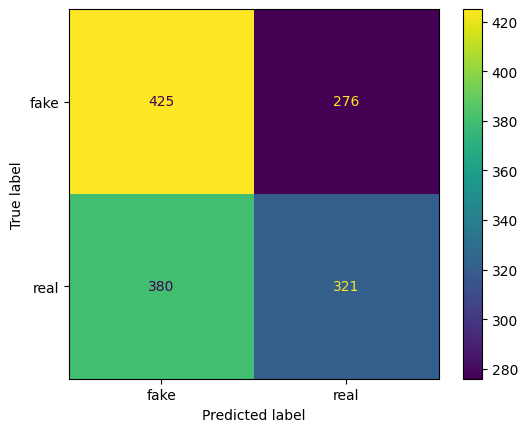

RandomForestClassifier training...
done in 19.982s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.023s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.50      0.50       701
        real       0.50      0.49      0.50       701

    accuracy                           0.50      1402
   macro avg       0.50      0.50      0.50      1402
weighted avg       0.50      0.50      0.50      1402

Confusion matrix for Facenet + RF:
[[354 347]
 [355 346]]


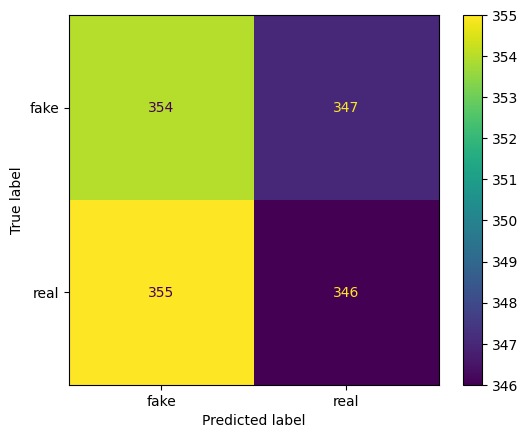

*********************
Fold 2

Deepface/Facenet
SVC training...
done in 30.828s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.334s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.53      0.61      0.57       701
        real       0.54      0.46      0.50       701

    accuracy                           0.54      1402
   macro avg       0.54      0.54      0.53      1402
weighted avg       0.54      0.54      0.53      1402

Confusion matrix for Facenet + SVM:
[[428 273]
 [378 323]]


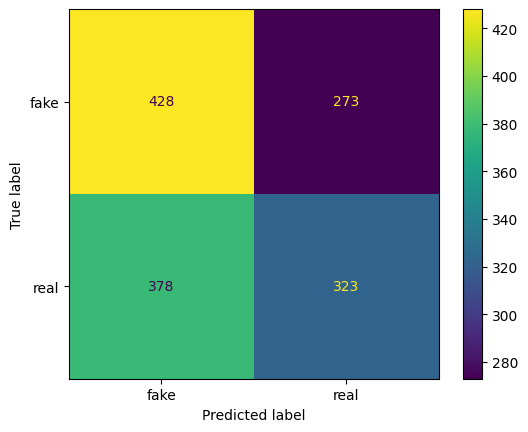

RandomForestClassifier training...
done in 18.377s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=150)
Predicting
done in 0.034s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.48      0.49       701
        real       0.49      0.50      0.49       701

    accuracy                           0.49      1402
   macro avg       0.49      0.49      0.49      1402
weighted avg       0.49      0.49      0.49      1402

Confusion matrix for Facenet + RF:
[[339 362]
 [352 349]]


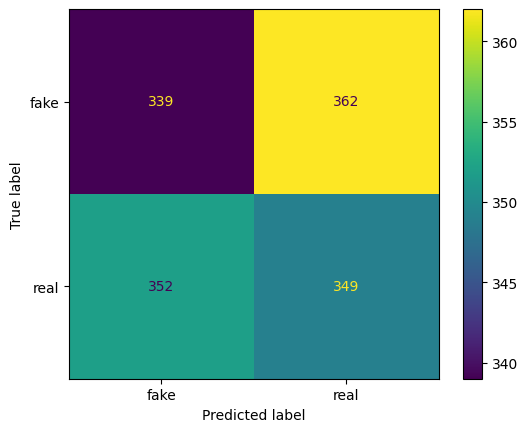

*********************
Fold 3

Deepface/Facenet
SVC training...
done in 31.595s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.005)
Predicting
done in 0.345s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.51      0.61      0.56       700
        real       0.52      0.41      0.46       702

    accuracy                           0.51      1402
   macro avg       0.51      0.51      0.51      1402
weighted avg       0.51      0.51      0.51      1402

Confusion matrix for Facenet + SVM:
[[429 271]
 [413 289]]


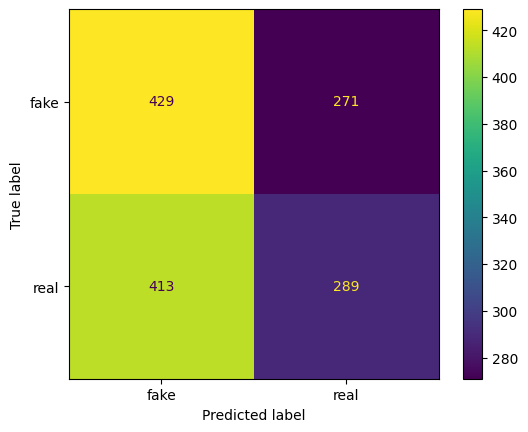

RandomForestClassifier training...
done in 19.814s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.023s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.48      0.49       700
        real       0.50      0.53      0.51       702

    accuracy                           0.50      1402
   macro avg       0.50      0.50      0.50      1402
weighted avg       0.50      0.50      0.50      1402

Confusion matrix for Facenet + RF:
[[335 365]
 [333 369]]


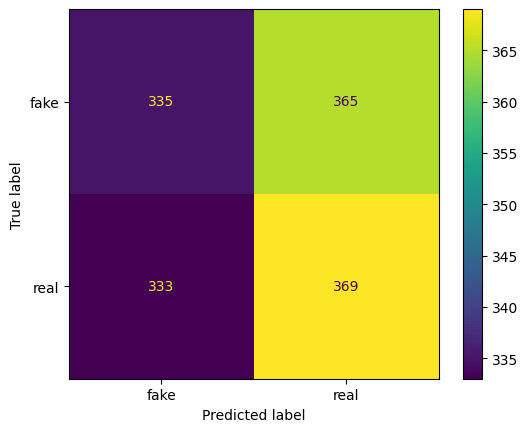

*********************
Fold 4

Deepface/Facenet
SVC training...
done in 31.194s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.005)
Predicting
done in 0.357s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.51      0.64      0.57       700
        real       0.52      0.39      0.45       701

    accuracy                           0.51      1401
   macro avg       0.52      0.51      0.51      1401
weighted avg       0.52      0.51      0.51      1401

Confusion matrix for Facenet + SVM:
[[445 255]
 [425 276]]


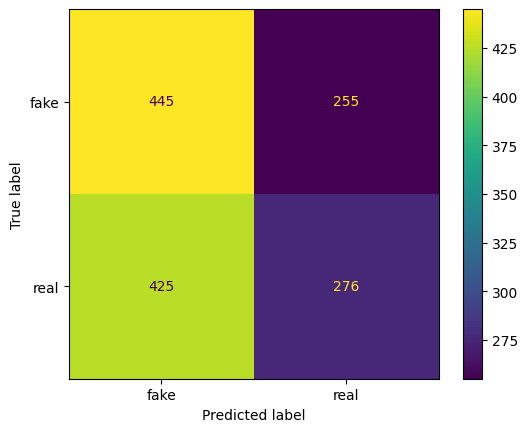

RandomForestClassifier training...
done in 20.616s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.047s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.49      0.49       700
        real       0.49      0.49      0.49       701

    accuracy                           0.49      1401
   macro avg       0.49      0.49      0.49      1401
weighted avg       0.49      0.49      0.49      1401

Confusion matrix for Facenet + RF:
[[346 354]
 [361 340]]


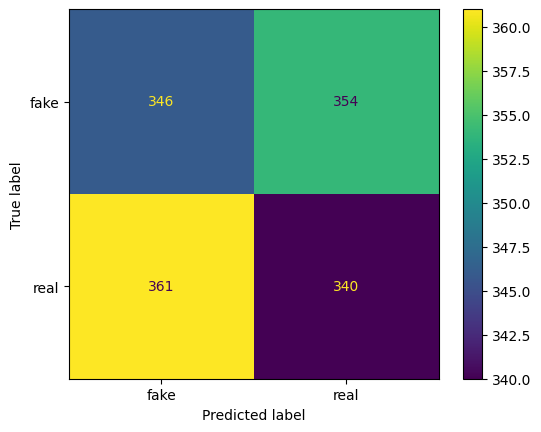

*********************
Fold 5

Deepface/Facenet
SVC training...
done in 30.920s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.326s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.50      0.63      0.56       700
        real       0.50      0.38      0.43       701

    accuracy                           0.50      1401
   macro avg       0.50      0.50      0.49      1401
weighted avg       0.50      0.50      0.49      1401

Confusion matrix for Facenet + SVM:
[[440 260]
 [437 264]]


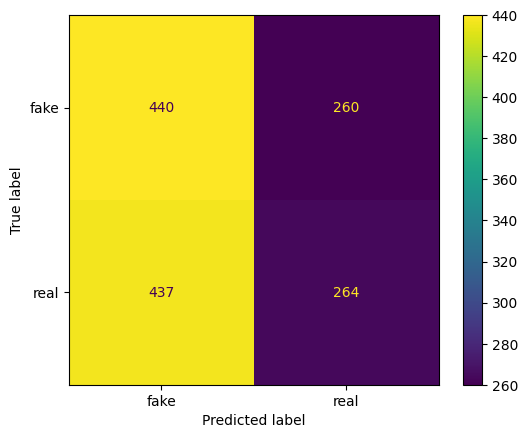

RandomForestClassifier training...
done in 18.524s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.047s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.51      0.50       700
        real       0.49      0.47      0.48       701

    accuracy                           0.49      1401
   macro avg       0.49      0.49      0.49      1401
weighted avg       0.49      0.49      0.49      1401

Confusion matrix for Facenet + RF:
[[358 342]
 [374 327]]


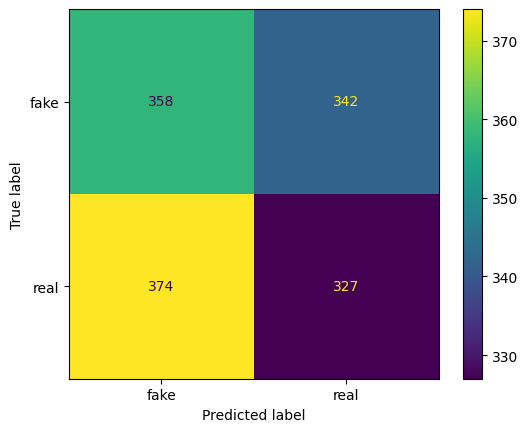

In [13]:
print("+++++++++++++++++++++++++++++++++++++++++++\n")

# KNN 
precs_facenet_svm, recs_facenet_svm, acc_facenet_svm = [], [], []

precs_facenet_rf, recs_facenet_rf, acc_facenet_rf = [], [], []

SVM = SVC(kernel='rbf', class_weight='balanced')
SVM_parameters = {
    'C': [1e3, 5e3],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
}

RF = RandomForestClassifier()
RF_parameters = {
    'n_estimators': [100, 150, 200],
}

fold = 1
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, Y):
    print("*********************\nFold %d" % fold)
        
    # Facenet - SVM
    print("\nDeepface/Facenet")
    XFaceNet = XFaceNet.reshape(-1, 1)
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index], Y[train_index], Y[test_index], SVM, SVM_parameters)
    print("\nDeepface/Facenet + SVM Metrics")
    precs_facenet_svm.append(precision_score(y_test, y_pred))
    recs_facenet_svm.append(recall_score(y_test, y_pred))
    acc_facenet_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for Facenet + SVM:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
        
    # Facenet - Random Forest
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index], Y[train_index], Y[test_index], RF, RF_parameters)
    print("\nDeepface/Facenet + RF Metrics")
    precs_facenet_rf.append(precision_score(y_test, y_pred))
    recs_facenet_rf.append(recall_score(y_test, y_pred))
    acc_facenet_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for Facenet + RF:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
        
    fold += 1